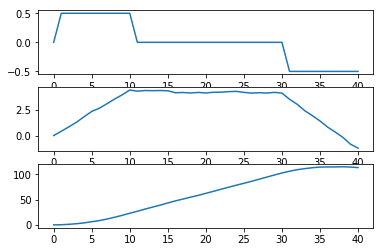

In [28]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

class Mobile() :
    def __init__(self) :
        self.dt = 1
        
    def reset(self) :
        self.acceleration = [0.0,]
        self.position = [0.0,]
        self.speed = [0.0,]
        self.time = [0,]
        
    def get_real_state(self) :
        return np.array([[p, s] for p, s in zip(self.position, self.speed)])
    
    def get_observed_state(self) :
        observed_position = (
            np.array(self.position)
            * np.random.normal(0.0, 1.0, (len(self.position,)))
        )
        observed_speed = (
            np.array(self.speed)
            * np.random.normal(0.0, 1.0, (len(self.speed,)))
        )
        return np.array([[p, s] for p, s in zip(observed_position, observed_speed)])

        
    def step(self, acceleration=0.0) :
        self.acceleration.append(acceleration)
        self.time.append(self.time[-1] + self.dt)
        self.speed.append(
            self.speed[-1] + (acceleration * self.dt) + random.gauss(0.0, 0.1)
        )
        self.position.append(
            self.position[-1]
            + (self.speed[-1] * self.dt)
            - math.copysign(random.gauss(0.1, 0.3), self.speed[-1])
        )
        
    def play_n_plot(self, acceleration_lst) :
        self.reset()
        for acceleration in acceleration_lst :
            self.step(acceleration)
            
        plt.subplot(3, 1, 1)
        plt.plot(self.time, self.acceleration)
        plt.subplot(3, 1, 2)
        plt.plot(self.time, self.speed)
        plt.subplot(3, 1, 3)
        plt.plot(self.time, self.position)
        plt.show()
      
m = Mobile()
m.play_n_plot(([0.5,] * 10) + ([0.0,] * 20) + ([-0.5,] * 10))

Pour cette découverte du filtre de Kalman, prenons l'exemple d'un petit mobile à roulettes, se déplaçant en ligne droite.

Le mobile est défini par son vecteur d'état, et récciproquement, le vecteur d'état contient toutes les informations nécessaire à la description du système. Ce sont ces paramètres qui vont être filtrés

$$
\vec{x} = \begin{bmatrix} p \\ v \end{bmatrix}
$$

Avec $p$ la position et $v$ la vitesse, suivant le seul axe de liberté du mobile.

En fait, l'état réel n'est jamais vraiment connu, par contre nous allons maintenir une meilleure estimée de l'état à l'instant $k$.

$$
\hat{x}_k = \begin{bmatrix} p \\ v \end{bmatrix}
$$

* $\hat{x}_k$, la meilleure estimée de l'état à l'instant $k$
* $p$, la position moyenne estimée
* $v$, la vitesse moyenne estimée

Mais également une information sur l'incertitude de mesure, et de leur corrélations, via la matrice de covariances, qui définit la quantité d'incertitude, pour chaque élément du vecteur d'état, ainsi que leur taux de corrélation.

$$
\mathbf{P}_k = 
\begin{bmatrix}
    \Sigma_{pp} & \Sigma_{pv} \\
    \Sigma_{vp} & \Sigma_{vv}
\end{bmatrix}
$$

* $\Sigma_{pp}$, l'incertitude sur la position
* $\Sigma_{vv}$, l'incertitude sur la vitesse
* $\Sigma_{pv}$ la corrélation d'incertitude entre la position est la vitesse. $\Sigma_{pv} = \Sigma_{vp}$, la matrice est symétrique

Il est possible de mettre en équation la position et la vitesse courante, par rapport à la position et la vitesse précédente, en se basant sur la physique du modèle.

$$
\begin{split}
p_k &= p_{k-1} + T &v_{k-1} \\
v_k &= &v_{k-1}
\end{split}
$$

ou, sous forme matricielle

$$
\hat{x}_k = \begin{bmatrix}
    1 & T \\
    0 & 1
\end{bmatrix} \hat{x}_{k-1}
$$

Soit

$$
\hat{x}_k = \mathbf{F}_k \hat{x}_{k-1}
$$

Avec $\mathbf{F}_k$ la matrice de prédiction

Si la covariance de $ x $ est représentée par la matrice $ \Sigma $ :

$$
Cov(x) = \Sigma
$$
    
Alors,

$$
Cov(\mathbf{A} x) = \mathbf{A} \Sigma \mathbf{A}^T
$$
    
On peut donc ré-écrire nos estimations d'état et de covariance courantes en fonctions des estimations précédentes.

$$
\begin{split}
\hat{x}_k &= \mathbf{F}_k \hat{x}_{k-1} \\
\mathbf{P}_k &= \mathbf{F}_k \mathbf{P}_{k-1} \mathbf{F}_k^T
\end{split}
$$

Mais il nous reste un phénomène à prendre en compte, la commande comme la physique du système sont connues. Disons que le module est commandé par une accération connue $ a $

$$ \begin{split} 
\color{deeppink}{p_k} &= \color{royalblue}{p_{k-1}} + T &\color{royalblue}{v_{k-1}} + \frac{1}{2} & T^2 & \color{darkorange}{a} \\ 
\color{deeppink}{v_k} &= &\color{royalblue}{v_{k-1}} + & T & \color{darkorange}{a}
\end{split} $$

Ce qui peut se mettre sous forme de matrice :

$$
\color{deeppink}{\mathbf{\hat{x}}_k} = \mathbf{F}_k \color{royalblue}{\mathbf{\hat{x}}_{k-1}} + \begin{bmatrix} 
\frac{1}{2}T^2 \\ 
T
\end{bmatrix} \color{darkorange}{a}
$$

Soit

$$
\color{deeppink}{\mathbf{\hat{x}}_k} = \mathbf{F}_k \color{royalblue}{\mathbf{\hat{x}}_{k-1}} + \mathbf{B}_k \color{darkorange}{\vec{u_k}}
$$

avec $ \mathbf{B}_k = \begin{bmatrix} \frac{1}{2}T^2 \\ T \end{bmatrix} $ la matrice de commande et $ \vec{u_k} $ le vecteur-ligne de commande.

On peut également prendre en compte des perturbations inconnues $ \mathbf{Q} $ qui contribuent à la mise à jour de la matrice de covariance $ \mathbf{P} $. L'équation totale devient donc :

$$ \begin{equation} 
\begin{split} 
\color{deeppink}{\hat{x}_k} &= \mathbf{F}_k \color{royalblue}{\hat{x}_{k-1}} + \mathbf{B}_k \color{darkorange}{\vec{u}_k} \\ 
\color{deeppink}{\mathbf{P}_k} &= \mathbf{F_k} \color{royalblue}{\mathbf{P}_{k-1}} \mathbf{F}_k^T + \color{mediumaquamarine}{\mathbf{Q}_k} 
\end{split}
\end{equation} $$



Il ne reste plus qu'à tenir compte de l'incertitude sur la mesure :
$$ \begin{split} 
\vec{z_k} &= \mathbf{H}_k \color{deeppink}{\mathbf{\hat{x}}_k} \\ 
\mathbf{Z_k} &= \mathbf{H}_k \color{deeppink}{\mathbf{P}_k} \mathbf{H}_k^T 
\end{split} $$

* $\mathbf{H}_k$, la matrice de projection des états sur les mesures
* $\vec{z_k}$, la valeur moyenne attendue sur les senseurs
* $Z_k$, l'erreur gaussienne attendue sur les senseurs

Dans l'exemple de notre mobile, deux capteurs de vitesse sont installés sur les roues et donnent la vitesse du mobile avec une erreur faible, et un télémètre donne la position, avec une erreur plus élevée

$$
\mathbf{H}_k = 
\begin{bmatrix}
    1 & 0 \\
    0 & 1 \\
    0 & 1
\end{bmatrix}
$$


Si on défini une distribution gaussienne sur un scalaire $\mathcal{G}(x)$ de moyenne $\mu$ et d'écart type $\sigma$ par la fonction suivante :

$$ \begin{equation}
\mathcal{G}(x, \mu, \sigma) = \frac{1}{ \sigma \sqrt{ 2\pi } } e^{ -\frac{ (x – \mu)^2 }{ 2\sigma^2 } } 
\end{equation} $$

On trouve que le produit (renormalisé) de deux gaussiennes $\mathcal{G}(x, \color{deeppink}{\mu_0}, \color{deeppink}{\sigma_0})$ et $\mathcal{G}(x, \color{royalblue}{\mu_1}, \color{royalblue}{\sigma_1})$ est paramétré par :

$$ \begin{equation}
\begin{split} 
\color{purple}{\mu} &= \color{deeppink}{\mu_0} + \frac{\color{deeppink}{\sigma_0^2} (\color{royalblue}{\mu_1} – \color{deeppink}{\mu_0})} {\color{deeppink}{\sigma_0^2} + \color{royalblue}{\sigma_1^2}}\\ 
\color{purple}{\sigma}^2 &= \color{deeppink}{\sigma_0}^2 – \frac{\color{deeppink}{\sigma_0}^4} {\color{deeppink}{\sigma_0}^2 + \color{royalblue}{\sigma_1}^2} 
\end{split} 
\end{equation} $$

En posant

$$\color{darkorange}{\mathbf{k}} = \frac{\color{deeppink}{\sigma_0}^2}{\color{deeppink}{\sigma_0}^2 + \color{royalblue}{\sigma_1}^2}$$

on obtient :

$$ \begin{equation} 
\begin{split} 
\color{purple}{\mu} &= \color{deeppink}{\mu_0} + &\color{darkorange}{\mathbf{k}} (\color{royalblue}{\mu_1} - \color{deeppink}{\mu_0})\\ 
\color{purlple}{\sigma}^2 &= \color{deeppink}{\sigma_0}^2 – &\color{darkorange}{\mathbf{k}} \color{deeppink}{\sigma_0}^2 
\end{split}
\end{equation} $$

Puis, sous forme matricielle, si on pose :
$$
\color{orange}{\mathbf{K}} = \color{deeppink}{\Sigma_0} (\color{deeppink}{\Sigma_0} + \color{royalblue}{\Sigma_1})^{-1} 
$$
On obtient :
$$
\begin{split} 
\color{purple}{\vec{\mu}} &= \color{deeppink}{\vec{\mu}_0} + & \color{darkorange}{\mathbf{K}} (\color{royalblue}{\vec{\mu}_1} – \color{deeppink}{\vec{\mu}_0}) \\ 
\color{purple}{\Sigma} &= \color{deeppink}{\Sigma_0} – &\color{orange}{\mathbf{K}} \color{deeppink}{\Sigma_0}
\end{split}
$$

In [29]:
class Kalman() :
    dt = 1
    def __init__(self) :
        self.estimated_state = np.matrix([0.0, 0.0]).T
        
        self.prediction_matrix = np.matrix([[1.0, self.dt], [0.0, 1.0]])
        self.command_matrix = np.matrix([0.5 * (self.dt**2), self.dt]).T
        self.covariance = np.matrix([[0.0, 0.0],[0.0, 0.0]])
        
        self.additionnal_prediction_noise = np.matrix([[0.1, 0.1],[0.1, 0.1]])
        
    def predict(self, command_vector) :
        new_estimated_state = (
            self.prediction_matrix @ self.estimated_state
            + self.command_matrix * command_vector
        )
        
        new_covariance = (
            self.prediction_matrix @ self.covariance @ self.prediction_matrix.T
            + self.additionnal_prediction_noise
        )
        
        return new_estimated_state, new_covariance
    
    def update(self) :
        
        
        
k = Kalman()
k.predict(np.matrix([0.5,]))

(matrix([[ 0.25],
         [ 0.5 ]]), matrix([[ 0.1,  0.1],
         [ 0.1,  0.1]]))